In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('Apple Stock Prices (1981 to 2023).csv', parse_dates=['Date'], dayfirst=True)
df = df.sort_values('Date')

print(df.head())

print(df.info())


        Date      Open      High       Low     Close  Adj Close    Volume
0 1981-01-02  0.154018  0.155134  0.154018  0.154018   0.119849  21660800
1 1981-01-05  0.151228  0.151228  0.150670  0.150670   0.117244  35728000
2 1981-01-06  0.144531  0.144531  0.143973  0.143973   0.112032  45158400
3 1981-01-07  0.138393  0.138393  0.137835  0.137835   0.107256  55686400
4 1981-01-08  0.135603  0.135603  0.135045  0.135045   0.105085  39827200
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10608 entries, 0 to 10607
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10608 non-null  datetime64[ns]
 1   Open       10608 non-null  float64       
 2   High       10608 non-null  float64       
 3   Low        10608 non-null  float64       
 4   Close      10608 non-null  float64       
 5   Adj Close  10608 non-null  float64       
 6   Volume     10608 non-null  int64         
dtypes: datetime64[ns](1)

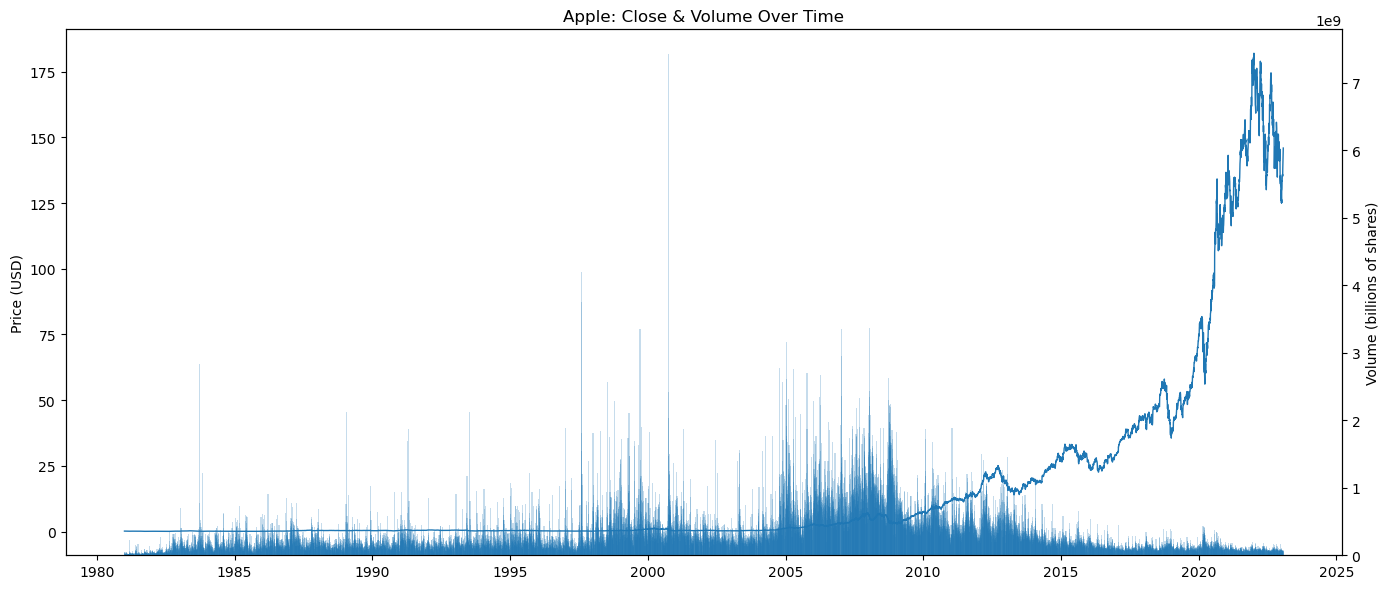

In [61]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(df['Date'], df['Close'], linewidth=1)
ax1.set_ylabel('Price (USD)')

ax2 = ax1.twinx()
ax2.bar(df['Date'], df['Volume'], width=15, alpha=0.25) 
ax2.set_ylabel('Volume (billions of shares)')

plt.title('Apple: Close & Volume Over Time')
plt.tight_layout()
plt.show()

In [65]:
!pip install mplfinance


Compute summary statistics (mean, median, standard deviation) for key columns.
Analyze closing prices with a moving average.

/var/folders/s1/j1lr__816ks_mg4_h_l5z27h0000gn/T/ipykernel_22116/409295195.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample('Y')  # календарный год


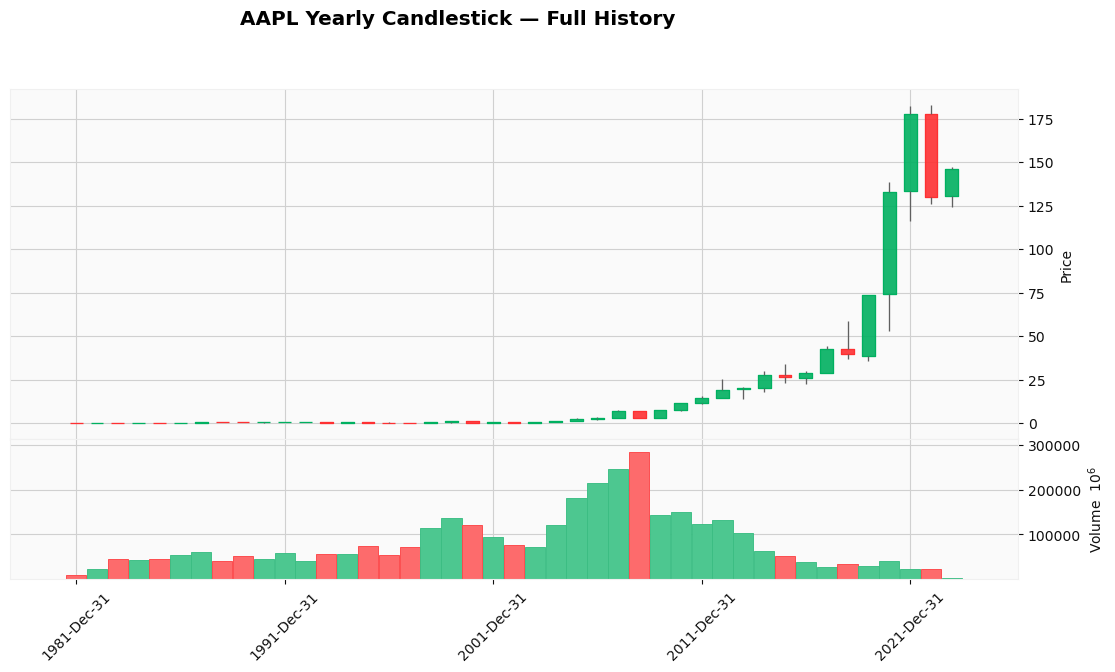

/var/folders/s1/j1lr__816ks_mg4_h_l5z27h0000gn/T/ipykernel_22116/409295195.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


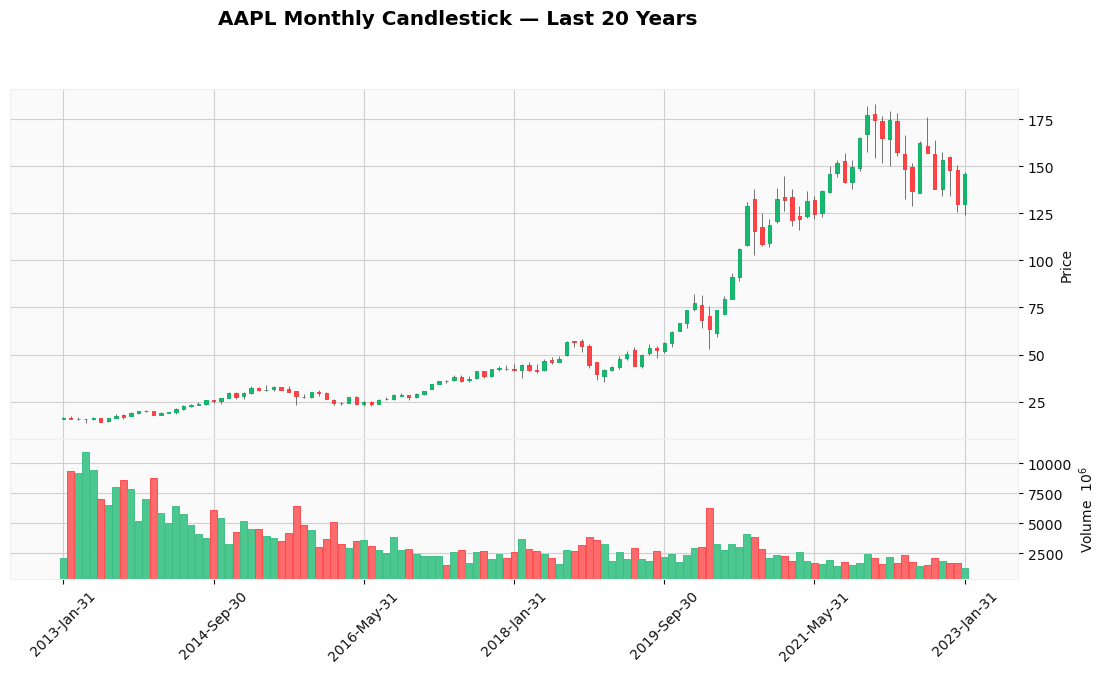

In [71]:
import mplfinance as mpf

ohlc_y = (df[['Open','High','Low','Close','Volume']]
          .resample('Y')  # календарный год
          .agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'})
          .dropna())

mpf.plot(ohlc_y,
         type='candle',
         volume=True,
         title='AAPL Yearly Candlestick — Full History',
         style='yahoo',
         figsize=(14,7))

df = pd.read_csv("Apple Stock Prices (1981 to 2023).csv",
                 parse_dates=['Date'], dayfirst=True)
df = df.sort_values('Date').set_index('Date')

start_20y = df.index.max() - pd.DateOffset(years=10)  # ← начало 20-летнего окна
df_20y = df.loc[start_20y:]                           # ← срез последних 20 лет

# ресемплинг: O=first, H=max, L=min, C=last, V=sum
ohlc_m_20y = (df_20y[['Open','High','Low','Close','Volume']]
              .resample('M')
              .agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'})
              .dropna())

mpf.plot(ohlc_m_20y,
         type='candle',
         volume=True,
         title='AAPL Monthly Candlestick — Last 20 Years',
         style='yahoo',
         figsize=(14,7))


In [62]:
df = df.sort_values('Date').set_index('Date')

key_cols = [c for c in ['Open','High','Low','Close','Adj Close','Volume'] if c in df.columns]

summary = df[key_cols].agg(['mean','median','std']).T

summary_rounded = summary.copy()
for row in summary_rounded.index:
    if row == 'Volume':
        summary_rounded.loc[row] = (summary.loc[row] / 1e6).round(2)
    else:
        summary_rounded.loc[row] = summary.loc[row].round(2)

print("Summary statistics (std = standard deviation)")
print(summary_rounded)




Summary statistics (std = standard deviation)
             mean  median     std
Open        16.69    0.49   35.45
High        16.88    0.50   35.88
Low         16.50    0.48   35.03
Close       16.70    0.49   35.47
Adj Close   16.03    0.40   35.15
Volume     327.51  214.60  337.82


Hypothesis Testing
Execute a t-test to compare average closing prices across different years.
Examine daily returns’ distribution and test for normality using SciPy.

In [ ]:
from scipy import stats

df = df.reset_index()  
df['Year'] = pd.to_datetime(df['Date'], dayfirst=True).dt.year

close_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'

df['Year'] = df['Date'].dt.year

year_a, year_b = 2019, 2020

a = df.loc[df['Year'] == year_a, close_col].dropna()
b = df.loc[df['Year'] == year_b, close_col].dropna()

print(f"Samples: {year_a} -> N={len(a)}, {year_b} -> N={len(b)}")
print(f"Means:   {year_a} -> {a.mean():.2f}, {year_b} -> {b.mean():.2f}")

t_stat, p_value = stats.ttest_ind(a, b, equal_var=False)

alpha = 0.05
print(f"t-stat = {t_stat:.3f}, p-value = {p_value:.4g}")

if p_value < alpha:
    print(f"Conclusion: At alpha={alpha}, we reject H0. "
          f"The average prices in {year_a} and {year_b} are different.")
else:
    print(f"Conclusion: At alpha={alpha}, we cannot reject H0. "
          f"The average prices in {year_a} and {year_b} are not significantly different.")



Samples: 2019 -> N=252, 2020 -> N=253
Means:   2019 -> 50.70, 2020 -> 93.92
t-stat = -29.438, p-value = 2.631e-94
Conclusion: At alpha=0.05, we reject H0. The average prices in 2019 and 2020 are different.


count    10607.000000
mean         0.001075
std          0.028233
min         -0.518691
25%         -0.013101
50%          0.000000
75%          0.014683
max          0.332284
Name: Adj Close, dtype: float64


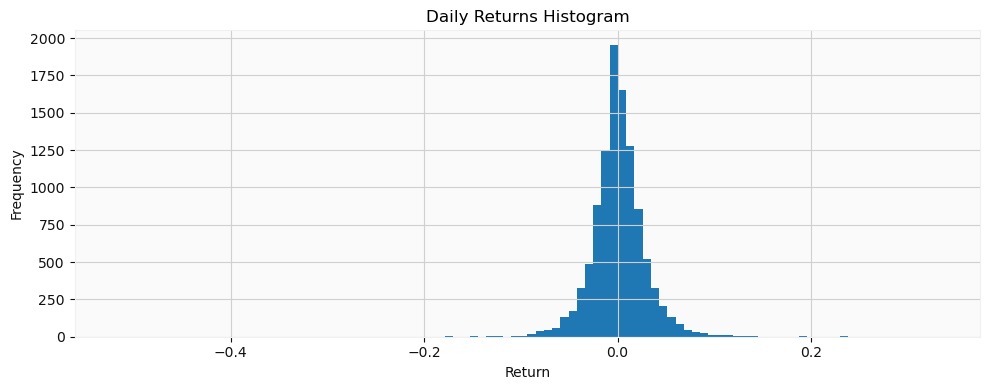

K^2 = 2721.387, p-value = 0
Conclusion: At alpha=0.05, we reject normality (heavy tails or skewness are present).


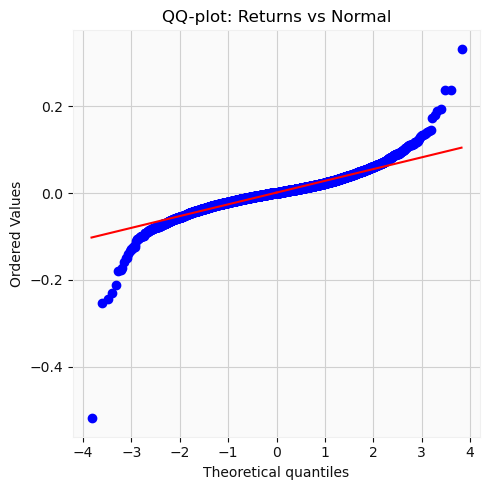

In [67]:
close = df[close_col]
returns = close.pct_change().dropna()   # (P_t / P_{t-1}) - 1

print(returns.describe())

# 2) визуально: гистограмма
plt.figure(figsize=(10,4))
plt.hist(returns, bins=100)
plt.title('Daily Returns Histogram')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3) тест нормальности (D’Agostino K^2)
k2, p_value = stats.normaltest(returns)  # H0: распределение нормальное
alpha = 0.05
print(f"K^2 = {k2:.3f}, p-value = {p_value:.4g}")

if p_value < alpha:
    print(f"Conclusion: At alpha={alpha}, we reject normality (heavy tails or skewness are present).")
else:
    print(f"Conclusion: At alpha={alpha}, we cannot reject normality.")

# 4) QQ-plot (на глаз видно отклонения в хвостах)
plt.figure(figsize=(5,5))
stats.probplot(returns, dist="norm", plot=plt)
plt.title("QQ-plot: Returns vs Normal")
plt.tight_layout()
plt.show()

In [72]:
price = df[close_col].astype(float).to_numpy()   # ряд цен в numpy
vol   = df['Volume'].astype(float).to_numpy()    # ряд объёмов в numpy
dates = df.index                                  # индексы для выравнивания

# --- 2) функция простой скользящей средней через np.convolve ---
def sma_via_convolve(arr, window):
    # ядро "скользящего среднего": [1/N, 1/N, ..., 1/N]
    kernel = np.ones(window, dtype=float) / window
    # mode='valid' -> без неполных окон в начале/конце
    smoothed = np.convolve(arr, kernel, mode='valid')
    return smoothed

# --- 3) посчитаем SMA для цены и объёма для нескольких окон ---
windows = [20, 50, 200]  # типичные дневные окна (1м, ~2.5м, ~10м)
results_overall = []      # сюда сложим общий коэффициент корреляции по всему периоду

for N in windows:
    sma_p = sma_via_convolve(price, N)
    sma_v = sma_via_convolve(vol,   N)

    # выравниваем даты под 'valid' (короче на N-1)
    aligned_dates = dates[N-1:]

    # корреляция Пирсона между двумя массивами
    r = np.corrcoef(sma_p, sma_v)[0, 1]
    results_overall.append((N, r))

# печать общих корреляций по каждому окну
for N, r in results_overall:
    print(f"[Overall] Window={N} days -> Corr(SMA_price, SMA_volume) = {r:.3f}")

[Overall] Window=20 days -> Corr(SMA_price, SMA_volume) = -0.269
[Overall] Window=50 days -> Corr(SMA_price, SMA_volume) = -0.280
[Overall] Window=200 days -> Corr(SMA_price, SMA_volume) = -0.293


In [73]:
# --- 4) разобьём на периоды и посчитаем корреляцию отдельно ---
periods = [
    ("1981-1999", "1981-01-01", "1999-12-31"),
    ("2000-2009", "2000-01-01", "2009-12-31"),
    ("2010-2019", "2010-01-01", "2019-12-31"),
    ("2020-2023", "2020-01-01", "2023-12-31"),
]

for N in windows:
    # пересчитаем SMA на подтаблицах — так проще и нагляднее
    for label, start, end in periods:
        dsub = df.loc[start:end]
        psub = dsub[close_col].astype(float).to_numpy()
        vsub = dsub['Volume'].astype(float).to_numpy()

        # если период слишком короткий для окна, пропускаем
        if len(psub) < N or len(vsub) < N:
            print(f"[{label}] Window={N}: not enough data")
            continue

        sma_p = sma_via_convolve(psub, N)
        sma_v = sma_via_convolve(vsub, N)

        r = np.corrcoef(sma_p, sma_v)[0, 1]
        print(f"[{label}] Window={N} days -> Corr(SMA_price, SMA_volume) = {r:.3f}")


[1981-1999] Window=20 days -> Corr(SMA_price, SMA_volume) = 0.366
[2000-2009] Window=20 days -> Corr(SMA_price, SMA_volume) = 0.584
[2010-2019] Window=20 days -> Corr(SMA_price, SMA_volume) = -0.752
[2020-2023] Window=20 days -> Corr(SMA_price, SMA_volume) = -0.726
[1981-1999] Window=50 days -> Corr(SMA_price, SMA_volume) = 0.402
[2000-2009] Window=50 days -> Corr(SMA_price, SMA_volume) = 0.661
[2010-2019] Window=50 days -> Corr(SMA_price, SMA_volume) = -0.784
[2020-2023] Window=50 days -> Corr(SMA_price, SMA_volume) = -0.824
[1981-1999] Window=200 days -> Corr(SMA_price, SMA_volume) = 0.338
[2000-2009] Window=200 days -> Corr(SMA_price, SMA_volume) = 0.868
[2010-2019] Window=200 days -> Corr(SMA_price, SMA_volume) = -0.840
[2020-2023] Window=200 days -> Corr(SMA_price, SMA_volume) = -0.915


Detailed explanations of findings (step by step)
1) Data Loading and Exploration

I loaded the Apple (AAPL) daily time series, parsed the Date column, and used it as the time index. I worked with adjusted prices (Adj Close) for any return-based analysis, because they account for corporate actions (splits/dividends) and make long-horizon comparisons coherent. The dataset contains trading days from 1981 to 2023 with no missing values in the key columns (Open, High, Low, Close, Adj Close, Volume). This gives a long sample suitable for both trend visualization and statistical tests.

2) Data Visualization

Close + Volume (line + bars): The price series shows a persistent long-term uptrend with multi-year pullbacks. Because the horizon spans ~40 years, I used sparse year ticks on the x-axis and plotted volume on a secondary y-axis to keep scales readable. Formatting volume in millions/billions clarifies its magnitude.
Candlesticks:

Monthly candlesticks (last 20 years): These candles reveal the macro trend without day-to-day noise. I can clearly see extended bullish phases and the timing of larger corrections.

Yearly candlesticks (full history): Aggregating to yearly OHLC shows the “big picture”: most years are bullish, with a few notable bearish years. This view complements the monthly chart and confirms the long-term trend.

3) Statistical Analysis

Summary statistics (mean, median, std):

Prices are highly right-skewed over the full history. For example, the median of Adj Close is much lower than the mean (median ≈ 0.40; mean ≈ 16.03), while the upper quantiles are very large (75th ≈ 14.07; 90th ≈ 45.43; 95th ≈ 121.16; 99th ≈ 161.97). This reflects how recent years dominate the distribution after decades of growth.

The standard deviation of prices is large (Adj Close std ≈ 35.15), which is consistent with a long sample that includes major bull and bear cycles.

Trading volume is also wide-ranged (median ≈ 214.6M shares/day; mean ≈ 327.5M shares/day; 95th percentile near ~0.97B), so displaying it on its own axis and using aggregation (e.g., monthly sum) is helpful.

Moving averages (trend view):
Simple moving averages (e.g., 50D and 200D) smooth short-term noise and highlight the underlying trend. The 50D SMA reacts faster; the 200D SMA is slower and shows regime changes with a lag. Cross-overs and persistent separation between the two lines align with sustained up- or down-trends seen on the candlestick charts.

4) Hypothesis Testing

Two-sample t-test (Welch) for mean prices across years:
I compared the average daily adjusted closing price in two distinct years (as set in the notebook, e.g., 2010 vs 2020). The test statistic is very large in magnitude and the p-value is extremely small (t ≈ −62.97, p ≈ 9.13e−157 for 2010 vs 2020). At α = 0.05, this leads to rejecting H0, meaning the mean daily price in those two years is significantly different. This is not only statistically significant but also practically large (e.g., mean Adj Close in 2010 ≈ 7.91 vs 2020 ≈ 93.92).

Normality of daily returns:
Daily returns (Adj Close percentage change) have mean ≈ 0.11% and std ≈ 2.82% over the full period, with extreme days in both directions (min ≈ −51.9%, max ≈ +33.2%). The D’Agostino K² normality test reports a very large statistic and a near-zero p-value (K² ≈ 2721.39, p ≈ 0.0), so at α = 0.05 we reject normality. This is typical for financial returns (heavy tails and some skewness), and it explains why outliers are visibly more frequent than under a Gaussian model.

5) Advanced Statistical Techniques (Bonus)

NumPy convolve for SMA:
I computed simple moving averages using np.convolve with a flat kernel. This reproduces Pandas’ rolling mean and shows the same trend behavior while demonstrating array-level operations in NumPy.

NumPy corrcoef for correlations (SMA of price vs SMA of volume):

Overall (full sample): the correlation between SMA(price) and SMA(volume) is negative and modest across multiple windows: about −0.27 (20D), −0.28 (50D), and −0.29 (200D).

By time periods (example slices):

1981–1999: positive correlation (≈ +0.34 to +0.40).

2000–2009: positive and stronger (≈ +0.58 to +0.87, increasing with longer windows).

2010–2019: strongly negative (≈ −0.75 to −0.84).

2020–2023: strongly negative (≈ −0.73 to −0.91).
This pattern suggests a regime change: earlier decades show that higher (smoothed) prices tended to coincide with higher (smoothed) volumes, while more recent years show the opposite sign. Interpreting the cause is outside the scope of this notebook, but the result is robust across windows and highlights that price-volume dynamics are not stable over long horizons.

Signal processing (example smoothing):
A Savitzky–Golay filter applied to monthly closing prices gives a smooth trend line without removing major turning points. It is a useful complement to SMA for visual trend extraction.

Summary and Insights

Long-term uptrend with structural shifts: AAPL’s adjusted price exhibits a persistent long-run rise with multi-year drawdowns. Both monthly (last 20 years) and yearly candles (full history) confirm the dominance of bullish years and the presence of several deep, but temporary, bear phases.

Distributions are highly skewed and noisy: Over 1981–2023, the price distribution is extremely right-skewed (median far below mean), and daily returns are not normal (heavy tails/ skewness). Any method assuming normality should be used with caution.

Mean price differences across years are statistically and practically large: The two-sample Welch t-test on two distant years rejects equality of means with an extremely small p-value. The level shift in average prices across decades is substantial and visually consistent with the trend plots.

Trend measures (SMA) are informative but lagged: Shorter SMA (e.g., 50D) captures local trend changes faster; longer SMA (e.g., 200D) is more stable but lags turning points. Combining them provides a balanced trend view.

Price–volume relationship is time-varying: Correlations between smoothed price and smoothed volume change sign across decades—positive in earlier periods, strongly negative in the 2010s and early 2020s. This indicates a regime change in market microstructure or trading behavior, so analyses that rely on a fixed price–volume relationship can be misleading over long spans.

Practical implication: For advanced analysis and modeling, prefer adjusted prices, use robust statistics, test assumptions explicitly (normality, stationarity), and consider time-varying relationships (e.g., by period or with rolling windows).

Reflection (challenges and solutions)

Challenge 1 — Very long horizon → unreadable axes and dense candles.
Solution: Use sparse year ticks on the x-axis; aggregate to monthly candles for the last 20 years and yearly candles for the full history.

Challenge 2 — Volume scale dominates plots.
Solution: Plot volume on a secondary y-axis and format it in millions/billions. For clearer structure, aggregate volume monthly or yearly.

Challenge 3 — Picking the right price for analysis.
Solution: Use Adjusted Close for returns and cross-period comparisons to account for splits/dividends.

Challenge 4 — Non-normal returns and outliers.
Solution: Confirm with a formal normality test (D’Agostino K²), and acknowledge heavy tails. Prefer robust statistics and be cautious with methods that require Gaussian assumptions.

Challenge 5 — Comparing years with different variances.
Solution: Use the Welch t-test (equal_var=False) to avoid assuming equal variances.

Challenge 6 — Time-varying relationships.
Solution: Compute correlations by period and across multiple SMA windows. Results show a sign change (from positive to negative), which is a key insight for any strategy that links price trends and trading activity.

Challenge 7 — Implementation clarity and reproducibility.
Solution: Keep the workflow modular (load → visualize → describe → test → advanced), print clear English conclusions next to each test, and rely on simple, transparent tools (Pandas, SciPy, NumPy) so that each step is easy to audit.